In [1]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import trange,tqdm
sys.path.append('./include')
import ml4s
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s._set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


# Problem 3

## Part a

In [58]:
!ls

Assignment 03.ipynb  image_target.json	include  mcm41_reduced.png


In [59]:
img = plt.imread("mcm41_reduced.png")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


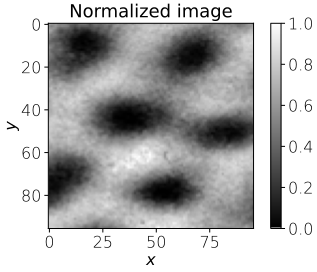

In [60]:
# normalize
max_val = float(img.max())
#print(max_val)

x_dim, y_dim = img.shape

norm_img = np.zeros_like(img)

for i in range(x_dim):
    for j in range(y_dim):
        norm_img[i, j] = img[i, j] / max_val

# Print the normalized image
plt.imshow(norm_img, cmap='gray')
plt.colorbar()
plt.title("Normalized image")
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

## Part b

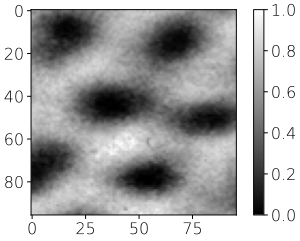

In [61]:
def img_target(x0_raw, x1_raw):
    x0 = np.floor(x0_raw * x_dim*0.9999).astype(int)
    x1 = np.floor(x1_raw * y_dim*0.9999).astype(int)
    return norm_img[x0, x1]

grid_size = 96
batch_size = grid_size**2

extent = [0, 1, 0, 1]

X = np.meshgrid(np.linspace(extent[0],extent[1],grid_size,dtype=float),
                np.linspace(extent[2],extent[3],grid_size,dtype=float), indexing='ij')

aₒ = np.zeros([batch_size,2])
aₒ[:,0] = X[0].flatten()
aₒ[:,1] = X[1].flatten()

result = img_target(*X)

plt.imshow(result, cmap='gray')
plt.colorbar()

## Part c

In [62]:
def feed_forward(aₒ,w,b):
    '''Propagate an input vector x = aₒ through 
       a network with weights (w) and biases (b).
       Return: activations (a) and derivatives f'(z).'''
    
    a,df = [aₒ],[]
    for wℓ,bℓ in zip(w,b):
        zℓ = np.dot(a[-1],wℓ) + bℓ
        _a,_df = ffprime(zℓ)
        a.append(_a)
        df.append(_df)
        
    return a,df

def backpropagation(y,a,w,b,df): 
    '''Inputs: results of a forward pass
       Targets     y: dim(y)  = batch_size ⨯ nL
       Activations a: dim(a)  = L ⨯ batch_size ⨯ nℓ
       Weights     w: dim(w)  = L-1 ⨯ nℓ₋₁ ⨯ nℓ
       Biases      b: dim(b)  = L-1 ⨯ nℓ
       f'(z)      df: dim(df) = L-1 ⨯ batch_size ⨯ nℓ
       
       Outputs: returns mini-batch averaged gradients of the cost function w.r.t. w and b
       dC_dw: dim(dC_dw) = dim(w)
       dC_db: dim(dC_db) = dim(b)
    '''
    
    num_layers = len(w)
    L = num_layers-1        
    batch_size = len(y)
    
    # initialize empty lists to store the derivatives of the cost functions
    dC_dw = [None]*num_layers
    dC_db = [None]*num_layers
    Δ = [None]*num_layers
    
    # perform the backpropagation
    for ℓ in reversed(range(num_layers)):
        
        # treat the last layer differently
        if ℓ == L:
            Δ[ℓ] = (a[ℓ] - y)*df[ℓ]
        else: 
            Δ[ℓ] = (Δ[ℓ+1] @ w[ℓ+1].T) * df[ℓ]
            
        dC_dw[ℓ] = (a[ℓ-1].T @ Δ[ℓ]) / batch_size
        dC_db[ℓ] = np.average(Δ[ℓ],axis=0)
        
    return dC_dw,dC_db

def gradient_step(η,w,b,dC_dw,dC_db):
    '''Update the weights and biases as per gradient descent.'''
    
    for ℓ in range(len(w)):
        w[ℓ] -= η*dC_dw[ℓ]
        b[ℓ] -= η*dC_db[ℓ]
    return w,b

def train_network(x,y,w,b,η):
    '''Train a deep neural network via feed forward and back propagation.
       Inputs:
       Input         x: dim(x) = batch_size ⨯ n₁
       Target        y: dim(y) = batch_size ⨯ nL
       Weights       w: dim(w)  = L-1 ⨯ nℓ₋₁ ⨯ nℓ
       Biases        b: dim(b)  = L-1 ⨯ nℓ
       Learning rate η
       
       Outputs: the least squared cost between the network output and the targets.
       '''
    
    a,df = feed_forward(x,w,b)
    
    # we pass a cycled a by 1 layer for ease of indexing
    dC_dw,dC_db = backpropagation(y,a[1:]+[a[0]],w,b,df)
    
    w,b = gradient_step(η,w,b,dC_dw,dC_db)
    
    return 0.5*np.average((y-a[-1])**2)

def make_batch(n,batch_size,extent,func):
    '''Create a mini-batch from our inputs and outputs.
    Inputs:
    n0        : number of neurons in each layer
    batch_size: the desired number of samples in the mini-batch
    extent    : [min(xₒ),max(xₒ), min(x₁),max(x₁),…,min(x_{n[0]-1}),max(x_{n[0]-1})]
    func:     : the desired target function.
    
    Outputs: returns the desired mini-batch of inputs and targets.
    '''
    
    x = np.zeros([batch_size,n[0]])
    for i in range(n[0]):
        x[:,i] = np.random.uniform(low=extent[2*i],high=extent[2*i+1],size=[batch_size])

    y = func(*[x[:,j] for j in range(n[0])]).reshape(-1,n[-1])
    
    return x,y 

In [130]:
n = [2, 200, 100, 50, 20, 10, 1]
w,b = [],[]
for ℓ in range(len(n)-1):
    w.append(np.random.uniform(low=-5,high=5,size=(n[ℓ],n[ℓ+1])))
    b.append(np.random.uniform(low=-5,high=5, size=n[ℓ+1]))

In [64]:
def ffprime(z): 
    '''calculate f(z) and f'(z); sigmoid.'''
    _f = 1.0/(1.0+np.exp(-z))
    return _f,np.exp(-z)*(_f**2)

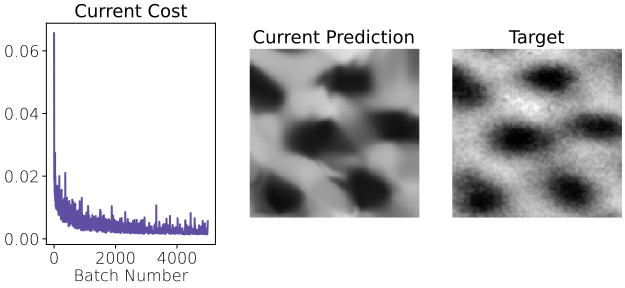

In [131]:
from IPython.display import clear_output,display
from time import sleep
η = 2.1

batch_size = 400
num_steps = 5000
plot_ratio = int(num_steps / 50)

costs = np.zeros(num_steps)
for j in range(num_steps):
    
    x,y = make_batch(n,batch_size,extent,img_target)
    costs[j] = train_network(x,y,w,b,η)
    
    # we plot every plot_ratio steps
    if not j % plot_ratio or j == num_steps-1:
        
        clear_output(wait=True)
        ret = feed_forward(aₒ,w,b)
        aL = ret[0][-1].reshape(grid_size,grid_size)
        fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(10,4))
        
        ax[1].axis('off')
        img = ax[1].imshow(aL, extent=extent, cmap='gray', rasterized=True, 
               interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)
        
        ax[2].axis('off')
        ax[2].imshow(img_target(*X), extent=extent, cmap='gray', rasterized=True, 
           interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)

        ax[0].plot(costs)

        ax[0].set_title("Current Cost")
        ax[0].set_xlabel("Batch Number")
        ax[1].set_title("Current Prediction")
        ax[2].set_title("Target")

        plt.show()
        
        # uncoment if plotting is too fast
        #sleep(0.1)

In [153]:
import json

In [154]:
filename="image_target.json"
data={
    "topology": n,
    "eta": η,
    "batch size": batch_size
}

with open(filename, "w") as outfile:
    json.dump(data, outfile, indent=1)

## Part d

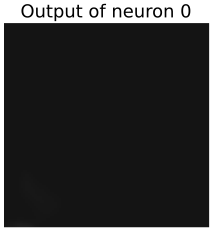

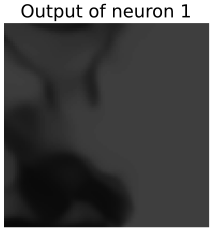

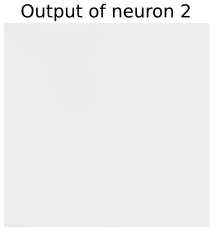

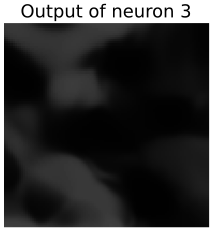

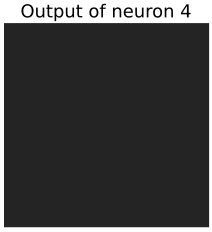

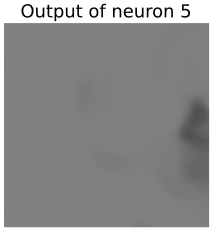

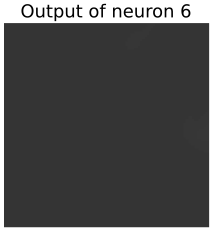

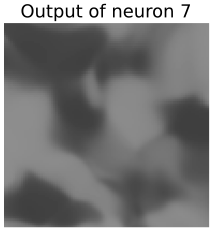

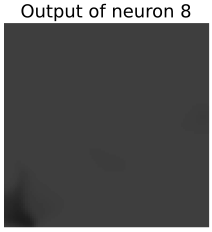

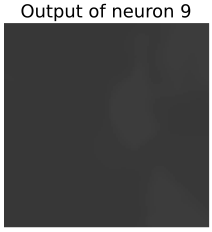

In [152]:
import copy
#fig,ax = plt.subplots(ncols=5,nrows=2,figsize=(5,2))

for n in range(len(w[-1])):

    w_last_modified = copy.deepcopy(w)

    for i in range(len(w_last_modified[-1])):
        if (i != n):
            w_last_modified[-1][i] = 0

    
    ret = feed_forward(aₒ,w_last_modified,b)
    aL = ret[0][-1].reshape(grid_size,grid_size)
    plt.axis('off')
    plt.title(f'Output of neuron {n}')
    plt.imshow(aL, extent=extent, cmap='gray', rasterized=True, 
                       interpolation='nearest', origin='lower', aspect='equal',vmin=0, vmax=1)
    plt.show()

# Problem 4

## Part a

I will generate a set of curves, which will have a 50/50 chance of being a Lorentzian or a Gaussian.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

In [38]:
x_range=np.linspace(-5, 5, 1000)
data_set_size=1000

In [27]:
def N(A, μ, σ, x):
    return A * np.exp(-((x-μ)**2) / (2 * σ**2))

def L(A, μ, σ, x):
    return A / ( ((x-μ)/σ)**2 + 1 )

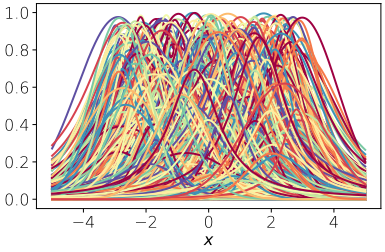

Number of Lorentzians = 504/1000
Number of Gaussians = 496/1000


In [39]:
data_set=[]
labels=[]

Number_L=0
Number_N=0

for i in range(data_set_size):
    r = np.random.choice([0, 1])
    
    A=np.random.uniform(0, 1)
    μ=np.random.uniform(-3, 3)
    σ=np.random.uniform(0.5, 1.5)
    
    if (r == 0):
        curve=L(A, μ, σ, x_range)
        Number_L += 1
        labels.append(0)
    else:
        curve=N(A, μ, σ, x_range)
        Number_N += 1
        labels.append(1)
    curve=list(curve)
    data_set.append(curve)
    plt.plot(x_range, curve)

plt.xlabel(r'$x$')
plt.show()

print(f'Number of Lorentzians = {Number_L}/{data_set_size}')
print(f'Number of Gaussians = {Number_N}/{data_set_size}')
        

## Part b

In [40]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_set, labels, test_size=0.1)

In [41]:
model = keras.Sequential(
[
    layers.Dense(10,input_shape=(len(x_range),),activation='relu'),
    layers.Dense(5,activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                10010     
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 6         
Total params: 10,071
Trainable params: 10,071
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy']) 

In [43]:
batch_size = 32
epochs = 100

training_history = {}
training_history['test'] = model.fit(x_train,y_train, epochs=epochs,validation_data=(x_test,y_test), verbose=0)

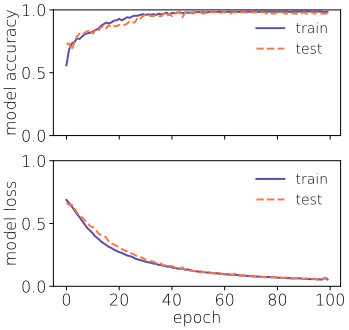

In [44]:
# look into training history
fig,ax = plt.subplots(2,1, sharex=True, sharey=True, figsize=(5,5))

# summarize history for accuracy
ax[0].plot(training_history['test'].history['accuracy'])
ax[0].plot(training_history['test'].history['val_accuracy'], ls='--', color=colors[-3])
ax[0].set_ylabel('model accuracy')
ax[0].legend(['train', 'test'], loc='best')
ax[0].set_ylim(0,1)

# summarize history for loss
ax[1].plot(training_history['test'].history['loss'])
ax[1].plot(training_history['test'].history['val_loss'], ls='--', color=colors[-3])
ax[1].set_ylabel('model loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'test'], loc='best');

In [45]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=2)

data_set=np.array(data_set)

predictions = np.zeros(data_set.shape[0],dtype=int)
predictions[np.where(model(data_set)>=0.5)[0]] = 1

mistakes = np.where(labels != predictions)[0]
num_mistakes = len(mistakes)

print(f'Num. Mistakes  = {num_mistakes}')

4/4 - 0s - loss: 0.0664 - accuracy: 0.9700
Num. Mistakes  = 15


For 10 functions, the model makes 1 mistake out of 10 with a loss of 0.0280.

For 100 functions, the model makes 5 mistake out of 100 with a loss of 0.4268. The test loss was higher, indicating some degree of overfitting.

For 1000 functions, the model makes 15 mistake out of 1000 with a loss of 0.0664.

## Part c

In [54]:
from sklearn.linear_model import LogisticRegression

In [55]:
logreg = LogisticRegression(C=1e5, max_iter=10000)
logreg.fit(data_set, labels)

LogisticRegression(C=100000.0, max_iter=10000)

In [56]:
logreg.score(data_set, labels)

0.993

It seems the accuracy is higher in case of logistic regression.

## Problem 5

My reference for the project will be [arXiv:1610.02746](arXiv:1610.02746), titled *Accelerate Monte Carlo Simulations with Restricted Boltzmann Machines*. My objective is to device a way to speed up Monte Carlo simulations in CMP by the application of neural networks. MC applied changed to the lattice one spin at a time at random, and accepts or rejects the changes based on some criteria. Essentially, we are sweeping the state space at random and trying to find a state where we have a correlated ground state. However, as the changes, say, spin-flips, are executed randomly, the acceptance ratio remains low and hence, MC is a slow process. Here, the authors have talked about using a Restricted Boltzmann Machine (RBM) which will identify the relevant features of the model and propose relevant updates which result in a higher acceptance ratio. At the very least, I would like to apply this technique to a simple square lattice with the Heisenberg model and demonstrate that we can converge to the correct ground state faster using this method.